# Background


PCA is a commonly used dimensionality reduction technique that seeks to maximize the sample variance of the centered and normalized data (formula from pg 23 of 2.6.2.5 in latex) where $X$ denotes the data matrix, and $\phi_1$ is the vector of loadings for the first principal component. A mathematically equivalent formulation is given by the eigenvectors of the covariance matrix $X^TX$, with the eigenvector associated with the largest eigenvalue corresponding to the first principal component. The process projects the data onto a lower dimension linear subspace, such that the data maintains as much of its original information as possible.


An issue with utilizing standard PCA arises when considering linear separability. Singular value decomposition is a linear transformation, and as such, PCA does not work well when subjected to data with nonlinear decision boundaries.


Kernel PCA is actually a more general case of standard PCA, and can generally handle nonlinear cases. The idea is to implement a nonlinear kernel function to project the data into a larger dimensional feature space where the data is then linearly separable, and then perform PCA. (figure 12.16 pg 587 microsoft).


The MNIST dataset, as we have previously discussed, is a widely utilized set for training machine learning models. The set of handwritten digits consists of 60,000 training images, and 10,000 testing images, all of which are normalized according to size and grayscale levels. In this set in particular, the data is confined to a nonlinear subspace.

# Theory

First, we assume we have a nonlinear transformation $\phi(x): D \rightarrow M$ with $D >> M$. Each vector in the entry matrix $A$ is then projected using $\phi(x_i)$ for all $x_i \in A$. Standard PCA can be used in this new feature space, but it is costly and inefficient. This process can be simplified using kernel methods. We define our kernel method as:

$$
\kappa(x_i, x_j) = exp(-\frac{\lVert x - y \rVert^2}{2\sigma^2}) = \phi(x_i)^T\phi(x_j)
$$

Generally speaking, we cannot assume that the projected features have zero mean. Thus we have to centralize the data:

$$
\widetilde\phi(x_n) = \phi(x_n) - \frac{1}{N}\sum_{i=1}^{N}\phi(x_i)
$$

The elements of the Gram matrix are then

$$
\begin{align*}
    \widetilde{K}_{nm} & = \widetilde\phi(x_n)^T\widetilde\phi(x_m)\\
        & = \phi(x_n)^T\phi(x_m) - \frac{1}{N}\sum_{i=1}^{N}\phi(x_n)^T\phi(x_i) - \frac{1}{N}\sum_{i=1}^{N}\phi(x_i)^T\phi(x_m) + \frac{1}{N^2}\sum\limits_{j=1}^N\sum\limits_{i=1}^N \phi(x_j)^T\phi(x_i)\\
        & = k(x_n,x_m) - \frac{1}{N}\sum_{i=1}^{N} k(x_i,x_m) - \frac{1}{N}\sum_{i=1}^{N} k(x_n,x_i) + \frac{1}{N^2}\sum\limits_{j=1}^N\sum\limits_{i=1}^N k(x_j,x_i)\\
\end{align*}
$$

Rewriting in matrix notation yields

$$
\widetilde{\bf K} = {\bf K - 1_{N}K - K1_{N} + 1_{N}K1_{N}}
$$

Where, by convention, ${\bf 1_{N}}$ is the $N \times N$ matrix with $1/N$ as entries. Using $\widetilde{\bf K}$ in place of ${\bf K}$ will ensure the projected features have zero mean. Now, we construct the $M$ x $M$ covarience matrix of the projected features using

$$
C = \frac{1}{N}\sum_{i=1}^{N}\phi(x_i)\phi(x_i)^T
$$

The eigenvalues and eigenvectors of $C$ are given by

$$
Cv_k = \lambda_{k}v_k \space\space\space \forall \space 1 \leq k \leq M
$$

It follows that

$$
(\frac{1}{N}\sum_{i=1}^{N}\phi(x_i)\phi(x_i)^T)v_k = \lambda_{k}v_k
$$

Let $a_k$ be a principal component in $\mathbb{R}^d$, then $v_k = \sum_{i=1}^{N}a_{k,i}\phi(x_i)$. Substituting this into the previous equation gives

$$
(\frac{1}{N}\sum_{i=1}^{N}\phi(x_i)\phi(x_i)^T)\sum_{j=1}^{N}a_{k,j}\phi(x_j) = \lambda_{k}\sum_{j=1}^{N}a_{k,j}\phi(x_j)
$$

Now we define the kernel function as $\kappa(x_i, x_j) = \phi(x_i)^T\phi(x_j)$. If we multiply the eigenvector equation on both sides by $\phi(x_l)^T$, then we get

$$
\begin{align*}
    \frac{1}{N}\sum_{i=1}^{N}\phi(x_i)^T\phi(x_i)\phi(x_i)^T\sum_{j=1}^{N}a_{k,j}\phi(x_j) = \lambda_{k}\sum_{j=1}^{N}a_{k,j}\phi(x_l)^T\phi(x_j) & \implies \sum_{i=1}^{N}\kappa(x_l, x_i)\sum_{j=1}^{N}a_{k,j}\kappa(x_i, x_j) = N\lambda_{k}\sum_{j=1}^{N}a_{k,j}\kappa(x_l, x_j)\\
    & \implies K^2a_k = N\lambda_{k}Ka_k\\
    & \implies Ka_k = N\lambda_{k}a_k
\end{align*}
$$

Thus, the kernel principal components are found using:

$$
y_k(x) = \phi(x)^Tv_k = \sum_{j=1}^{N}a_{k,j}\kappa(x, x_j)
$$

# Implementation

Before we start implementing kernel PCA in Python, we need to import the neccessary libraries and set up Google Colab

In [1]:
import numpy as np              # used for linear algebra methods
import matplotlib.pyplot as plt # used for plotting results 
import tensorflow as tf         # used to access the MNIST dataset
from tensorflow import keras    # used to access the MNIST dataset
import pandas as pd             # used to convert principal components to a data frame
import seaborn as sns           # used for graphing results

Kernel PCA consists of four steps:
1. Constructing the kernel matrix $K$ from the training data set
2. Centralizing $K$ by computing the Gram matrix $\widetilde{K}$
3. Computing the kernel principal components $y_k(x)$

Step 1: We create a function that takes in a training data set and sigma value and constructs the Gaussian kernel.

In [2]:
# Create Gaussian Kernel
def gaus_kernel(X, sigma):
	row, col = X.shape

	K = np.zeros([row, row])

	for i in range(0,row):
		for j in range(0,row):
			v_i = X[i]
			v_j = X[j]
			K[i,j] = np.exp(-np.linalg.norm(v_i.T - v_j.T)**2/(2 * np.power(sigma, 2)))

	return K

Step 2: We create a function to compute the Gram matrix to ensure the projected features are centralized.

In [3]:
# Construct the Gram Matrix
def gram_matrix(K):
	row, col = K.shape

	one_N = np.ones((row, col)) / row
	K_tilde = K - (one_N @ K) - (K @ one_N) + (one_N @ K @ one_N)
	return K_tilde

Step 3: Compute the kernel principal components $y_k(x)$

In [4]:
# Compute the kernel principal components
def compute_principal_components(K_tilde):
  eig_vals, eig_vectors = np.linalg.eigh(K_tilde)
  eig_vals, eig_vectors = eig_vals[::-1], eig_vectors[:, ::-1]

  return np.column_stack([eig_vectors[:, i] for i in range(len(eig_vectors))])


# Data

We will be using Kernel PCA to differentiate between handwritten zeros and ones using the first two principal components. The handwritten numbers are obtained from the MNIST dataset, which is a large database of handwritten digits used for training various image processing systems and machine learning models. Before we work with the dataset, we want to load the data in and convert it into matrices.

In [5]:
mnist = keras.datasets.mnist
(train_imgs, train_labels), (test_imgs, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


Here is the first image and its corresponding label from the training dataset:

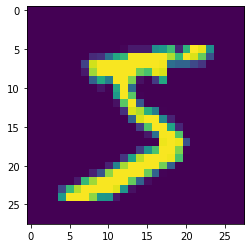

5


In [6]:
plt.figure()
plt.imshow(train_imgs[0])
plt.show()

print(train_labels[0])

Instead of performing PCA on all of the data, we will look at the zeros and ones specifically. We will need to filter the data accordingly.

In [9]:
i01 = [i for i in range(len(train_labels[0:10000])) if (train_labels[i]==0) or (train_labels[i]==1)]
train_imgs01 = train_imgs[i01]
train_labels01 = train_labels[i01]

The first sample in the subset is:

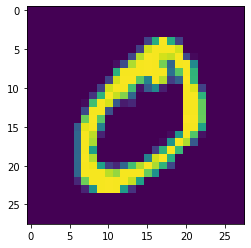

0


In [10]:
plt.figure()
plt.imshow(train_imgs01[0])
plt.show()

print(train_labels01[0])

Now we need to transform the samples into vectors:

In [11]:
X = np.vstack([train_imgs01[i].flatten() for i in range(len(train_labels01))])
y = train_labels01

Lastly, we will run our kernel PCA implementation on the samples and graph the first two principle components. The value for sigma was found using trial and error to achieve the best seperation.

[Text(0.5, 1.0, 'Image KernelPCA projection')]

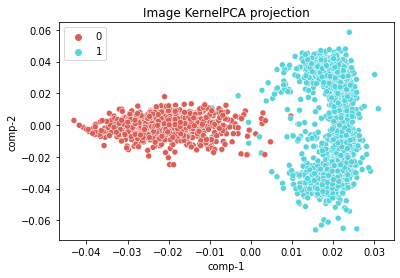

In [32]:
K = gaus_kernel(X, 2000)
K_tilde = gram_matrix(K)
K_kpca = compute_principal_components(K_tilde)

df = pd.DataFrame()
df["y"] = y[0:10000]
df["PC1"] = K_kpca[:,0]
df["PC2"] = K_kpca[:,1]

sns.scatterplot(x="PC1", y="PC2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Kernel PCA")

As we can see, the data is seperated well using two principal components. This data can be used in a linear classifier to predict the classification of future handwritten zeros or ones.

# References

- Bishop, Christopher M. Pattern Recognition
and Machine Learning. Springer, Cambridge, U.K., 2006.
- “Kernel Principal Component Analysis.” Wikipedia, Wikimedia Foundation, 24 Nov. 2021, https://en.wikipedia.org/wiki/Kernel_principal_component_analysis#:~:text=In%20the%20field%20of%20multivariate,a%20reproducing%20kernel%20Hilbert%20space.
- “MNIST Database.” Wikipedia, Wikimedia Foundation, 31 July 2022, https://en.wikipedia.org/wiki/MNIST_database. 
- Roch, Sebastien. “Chapter 4 - Optimization in Machine Learning.” MATH 535, 13 Mar. 2022, https://people.math.wisc.edu/~roch/mmids/roch-mmids-opt-1motiv.html.
- Wang, Quan. Kernel Principal Component Analysis and its Applications in
Face Recognition and Active Shape Models. Rensselaer Polytechnic Institute, Troy, N.Y, 2014. 